In [1]:
import sys
sys.path.append("../")

import pandas as pd
import matplotlib.pyplot as plt

from src.config import *
from src.retention import build_log_linear_retention
from src.cohorts import simulate_dau
from src.revenue import calculate_revenue
from src.scenarios import apply_sale, get_new_source_retention


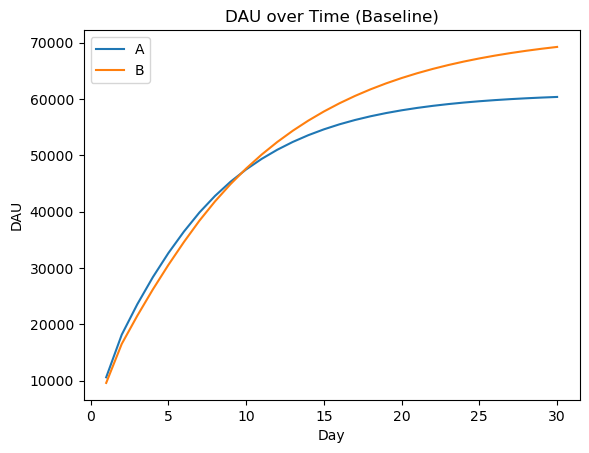

In [2]:
dau_data = {}

for v, cfg in VARIANTS.items():
    retention_fn = build_log_linear_retention(cfg["retention_points"])
    dau_data[v] = simulate_dau(retention_fn, DAILY_INSTALLS, DAYS)

df_dau = pd.DataFrame(dau_data)
df_dau.plot(title="DAU over Time (Baseline)")
plt.xlabel("Day")
plt.ylabel("DAU")
plt.show()


In [3]:
results = {}

for v, cfg in VARIANTS.items():
    revenue = calculate_revenue(
        df_dau[v],
        cfg["purchase_rate"],
        ARPPU,
        cfg["ads_per_dau"],
        cfg["ecpm"]
    )
    results[v] = {
        "Day15": revenue.loc[:15].sum(),
        "Day30": revenue.loc[:30].sum()
    }

pd.DataFrame(results)


,A,B
Day15,31100.807887,28427.054420
Day30,77787.434079,76260.611717


In [4]:
sale_results = {}

for v, cfg in VARIANTS.items():
    revenue = []
    for day in range(1, DAYS + 1):
        pr = apply_sale(cfg["purchase_rate"], day, SALE_START, SALE_END, SALE_UPLIFT)
        rev = calculate_revenue(
            df_dau.loc[day, v],
            pr,
            ARPPU,
            cfg["ads_per_dau"],
            cfg["ecpm"]
        )
        revenue.append(rev)
    sale_results[v] = sum(revenue[:30])

pd.DataFrame(sale_results, index=["Day30_Sale"])


,A,B
Day30_Sale,84129.854742,83217.966831


In [5]:
mixed_results = {}

for v, cfg in VARIANTS.items():
    old_ret = build_log_linear_retention(cfg["retention_points"])
    new_ret = get_new_source_retention(v)

    dau = []
    for day in range(1, DAYS + 1):
        active = 0
        for install_day in range(1, day + 1):
            age = day - install_day + 1
            if install_day >= NEW_SOURCE_START:
                active += OLD_SOURCE_INSTALLS * old_ret(age)
                active += NEW_SOURCE_INSTALLS * new_ret(age)
            else:
                active += DAILY_INSTALLS * old_ret(age)
        dau.append(active)

    revenue = calculate_revenue(
        pd.Series(dau),
        cfg["purchase_rate"],
        ARPPU,
        cfg["ads_per_dau"],
        cfg["ecpm"]
    )

    mixed_results[v] = revenue[:30].sum()

pd.DataFrame(mixed_results, index=["Day30_NewSource"])


,A,B
Day30_NewSource,81266.815167,79126.717955
